<a href="https://colab.research.google.com/github/yasp-g/portfolio/blob/on-deck/Berlin-vs-DC-overcast-visualization/BER-DC-overcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Becoming an Independent Data Scientist

## Region and Domain

The region and domain of interest for the project are: **Berlin, Germany** and **weather or climatological events**.

## Research Question

How do overcast rates in Berlin, Germany compare to rates in Washington, D.C., United States?

## Data Sources

### Germany data:


- Climatological data found using Deutsche Wetterdienst's (German Weather Service) [Climate Data Center](https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html).

  - Berlin Alexanderplatz sun (from 2015 to present):
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate_urban/hourly/sun/recent/

- Historical sunrise and sunset time data found using [sunrise.maplogs.com](https://sunrise.maplogs.com/)


### Washington, DC data:

- Climatological data found using [Visual Crossing's Weather Data database](https://www.visualcrossing.com/weather-data).

- Historical sunrise and sunset time data found using National Oceanic and Atmospheric Administration's [Local Climatological Data tool](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd).





## Image

## Discussion

# Method

## Notebook Setup

### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download and import necessary libraries

In [2]:
%%capture
!pip install remotezip

In [3]:
import pandas as pd
import numpy as np
import datetime 
from remotezip import RemoteZip
from itertools import groupby as iter_groupby
from operator import itemgetter

# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set_theme(style='darkgrid')

## Load data

### Berlin Data

The Berlin data was found from Germany's Deutsche Wetterdienst [Climate Data Center](https://www.dwd.de/DE/klimaumwelt/cdc/cdc_node.html). The CDC offers open access to a wide range of weather data all across Germany. One of the available weather stations is station ID 0399, in Berlin Alexanderplatz. This data is available in a remote directory, from which, sunshine duration (minutes) during each hour as far back as November 20th, 2015 is loaded below.

This data will be loaded as `df_ber`.

Sunrise and sunset data will also be needed. This was found on https://sunrise.maplogs.com.

This data will be loaded as `df_BERriseset`.


In [4]:
# define url of zipfile
zip_name = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate_urban/hourly/sun/recent/stundenwerte_sun_399_akt.zip"

# use RemoteZip to unpack and load .txt datafile from remote directory
with RemoteZip(zip_name) as ziploc:
    for zip_info in ziploc.infolist():
        # print(zip_info.filename)
        pass
    ziploc.extract('produkt_sun_399_akt.txt')

In [5]:
# read data from file
df_ber = pd.read_csv('produkt_sun_399_akt.txt', sep=';')

# strip whitespace from columns and drop 'eor' column
df_ber.rename(columns=lambda x: x.strip(), inplace=True)
df_ber.drop('eor', axis=1, inplace=True)
# df_ber.info()

In [6]:
# load data for df_BERriseset
df_BERriseset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coursera Courses/Applied Data Science with Python Specialization - U Michigan/2. Applied Plotting, Charting & Data Representation in Python/Assignments/Assignment 4/Data/Berlin data/Sunshine/Sunrise&set_maplogsdotcom.csv')
# df_BERriseset

### DC Data

DC climatological data was found using Visual Crossing's [Weather Data database](https://www.visualcrossing.com/weather-data). From this database, climatological data near Washington, DC for the years 2015 to 2021 was queired and loaded below. In this queiered data is "cloudcover" as a percent, for every hour of every day. Information on the exact weather station location is not provided.

This data will be loaded as `df_dc`.

Because cloudcover accounts for clouds during the night, sunrise and sunset data will also be needed. This was found using the National Oceanic and Atmospheric Administration's [Local Climatological Data tool](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd). This data was recorded by the weather station at Washington Reagan National Airport.

This data will be loaded as `df_DCriseset`.

In [7]:
# define file path and names
drive_path = '/content/drive/MyDrive/Colab Notebooks/Coursera Courses/Applied Data Science with Python Specialization - U Michigan/2. Applied Plotting, Charting & Data Representation in Python/Assignments/Assignment 4/Data/DC data/'
dc1_file = 'washington_dc climatological 2015 to 2017.csv'
dc2_file = 'washington_dc climatological 2018 to 2021.csv'

# read files
df_dc1 = pd.read_csv(drive_path + dc1_file)
df_dc2 = pd.read_csv(drive_path + dc2_file)


In [8]:
df_dc = pd.concat([df_dc1, df_dc2], ignore_index=True)
# df_dc.info()

In [9]:
# load data for df_DCriseset
dc3_file = 'NOAA LCD washington daily data.csv'
df_DCriseset = pd.read_csv(drive_path + dc3_file)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (35,36,42,43,44,50,52,74,76,77,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Filter dataframe columns and rename

In [10]:
df_ber = df_ber[['MESS_DATUM', 'SONNENSCHEINDAUER']]
df_ber = df_ber.rename(columns={'MESS_DATUM': 'datetime', 'SONNENSCHEINDAUER': 'sunduration'})

df_dc = df_dc[['datetime', 'cloudcover']]

df_BERriseset = df_BERriseset.rename(columns={'Date': 'datetime', 'Sunrise': 'sunrise_BER', 'Sunset': 'sunset_BER', 'Daylength': 'daylength_BER'})

df_DCriseset = df_DCriseset[['DATE', 'Sunrise', 'Sunset']].dropna().reset_index(drop=True)
df_DCriseset = df_DCriseset.rename(columns={'DATE': 'datetime', 'Sunrise': 'sunrise_DC', 'Sunset': 'sunset_DC'})

In [11]:
# df_ber, df_dc

## Data Cleaning

`df_ber` and `df_dc` are different lengths, and neither has length equal to the number of hours in the intended range (begining of 2016 to end of 2021) which is 52560.

### Standardize datetime columns

In [12]:
df_ber['datetime'] = pd.to_datetime(df_ber['datetime'], format='%Y%m%d%H')
df_ber.sort_values('datetime', inplace=True)

df_dc['datetime'] = pd.to_datetime(df_dc['datetime'])
df_dc.sort_values('datetime', inplace=True)

df_BERriseset['datetime'] = pd.to_datetime(df_BERriseset['datetime'])

df_DCriseset['datetime'] = df_DCriseset['datetime'].str.split('T').str[0]
df_DCriseset['datetime'] = pd.to_datetime(df_DCriseset['datetime'])

### Filter date range and add year, month, day, hour columns

In [13]:
startdate = pd.to_datetime('1/1/2016')
enddate = pd.to_datetime('1/1/2022')

df_ber = df_ber[(df_ber['datetime'] >= startdate) & (df_ber['datetime'] < enddate)].reset_index(drop=True)
df_dc = df_dc[(df_dc['datetime'] >= startdate) & (df_dc['datetime'] < enddate)].reset_index(drop=True)

len(df_ber), len(df_dc), len(df_BERriseset), len(df_DCriseset)

(50269, 52608, 2192, 2192)

### Remove Febuary 29th from data

In [14]:
df_ber = df_ber.drop(df_ber[(df_ber['datetime'].dt.month == 2) & 
                   (df_ber['datetime'].dt.day == 29)].index).reset_index(drop=True)
df_dc = df_dc.drop(df_dc[(df_dc['datetime'].dt.month == 2) & 
                 (df_dc['datetime'].dt.day == 29)].index).reset_index(drop=True)
df_BERriseset = df_BERriseset.drop(df_BERriseset[(df_BERriseset['datetime'].dt.month == 2) & 
                        (df_BERriseset['datetime'].dt.day == 29)].index).reset_index(drop=True)
df_DCriseset = df_DCriseset.drop(df_DCriseset[(df_DCriseset['datetime'].dt.month == 2) & 
                       (df_DCriseset['datetime'].dt.day == 29)].index).reset_index(drop=True)

len(df_ber), len(df_dc), len(df_BERriseset), len(df_DCriseset)

(50221, 52560, 2190, 2190)

### Duplicate rows found in `dc_df`

During the following "Dealing with missing rows" section, `dc_df` was found to have dupplicate datetime instances. This needs to be fixed first.

In [15]:
# find 'datetime' values with more than one occurance
dc_datevc = df_dc['datetime'].value_counts()
print(dc_datevc[dc_datevc > 1])

2019-11-03 01:00:00    2
2020-11-01 01:00:00    2
2016-11-06 01:00:00    2
2018-11-04 01:00:00    2
2017-11-05 01:00:00    2
2021-11-07 01:00:00    2
Name: datetime, dtype: int64


In [16]:
print(df_dc[df_dc['datetime'] == '2019-11-03 01:00:00'])
print(df_dc[df_dc['datetime'] == '2018-11-04 01:00:00'])
print(df_dc[df_dc['datetime'] == '2016-11-06 01:00:00'])
print(df_dc[df_dc['datetime'] == '2018-11-04 01:00:00'])
print(df_dc[df_dc['datetime'] == '2017-11-05 01:00:00'])
print(df_dc[df_dc['datetime'] == '2021-11-07 01:00:00'])

                 datetime  cloudcover
33624 2019-11-03 01:00:00         0.0
33625 2019-11-03 01:00:00         0.0
                 datetime  cloudcover
24888 2018-11-04 01:00:00         0.0
24889 2018-11-04 01:00:00         0.0
                datetime  cloudcover
7416 2016-11-06 01:00:00         0.0
7417 2016-11-06 01:00:00         0.0
                 datetime  cloudcover
24888 2018-11-04 01:00:00         0.0
24889 2018-11-04 01:00:00         0.0
                 datetime  cloudcover
16152 2017-11-05 01:00:00       100.0
16153 2017-11-05 01:00:00       100.0
                 datetime  cloudcover
51240 2021-11-07 01:00:00        79.3
51241 2021-11-07 01:00:00        90.1


It was already confirmed that each year had the appropriate number of values... (there are 8760 hours in a year).

Shown here:

In [17]:
for year in range(2016, 2022):
  print(f"year {year} has {len(df_dc[df_dc['datetime'].dt.year == year])} hours.")

year 2016 has 8760 hours.
year 2017 has 8760 hours.
year 2018 has 8760 hours.
year 2019 has 8760 hours.
year 2020 has 8760 hours.
year 2021 has 8760 hours.


So, each year has the appropriate number of hour timestamps, yet every year has a duplicate timestamp in November.

After some investigation, each year was found to be missing one timestamp in March:

In [18]:
# create a date range with all hours in the target range 
daterange = pd.date_range(start='2016-01-01', end='2022-01-01', freq='H', closed='left')

# remove leap days
leap=[]
for stamp in daterange:
    if stamp.month==2 and stamp.day ==29:
        leap.append(stamp)
daterange = daterange.drop(leap)

# this will show if any hours are missing
daterange.difference(df_dc['datetime'])

DatetimeIndex(['2016-03-13 02:00:00', '2017-03-12 02:00:00',
               '2018-03-11 02:00:00', '2019-03-10 02:00:00',
               '2020-03-08 02:00:00', '2021-03-14 02:00:00'],
              dtype='datetime64[ns]', freq=None)

At this point, the proper step would be to contact the data provider (Visual Crossing) to gain some context as to what may be causing this issue and determine a path forward together. 

For the sake of this project, it will be interpreted that all time stamps between the missing timestamp in March and the duplicate timestamp in November are one hour "late". All timestamps in this range will be shifted forwards one hour (only the first instance of a duplicated timestamp will be shifted).

#### Shifting offset timestamps

In [19]:
miss_times = daterange.difference(df_dc['datetime']).sort_values()
dc_datevc = df_dc['datetime'].value_counts()
dup_times = dc_datevc[dc_datevc > 1].index.sort_values()

# iterate over zip of missing and duplicate times and shift timestamps inbetween by 1 hour
for i in zip(miss_times, dup_times):
  df_dc.datetime = df_dc.datetime.map(lambda x: x - pd.Timedelta(1, 'h') if 
                                      (i[0] < x) & (x < i[1]) else x)

# shift the first occurance of each duplicate timestamp forward one hour
for duplicate in dup_times:
  if dup_times.empty:
    break
  index = df_dc.index[df_dc['datetime'] == duplicate][0]
  df_dc.loc[index, 'datetime'] -=  pd.Timedelta(1, 'h')

In [20]:
# confirm there are now no missing timestamps
daterange.difference(df_dc['datetime']).sort_values()

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [21]:
# confirm all 'datetime' values only occur once
df_dc['datetime'].value_counts()

2016-01-01 00:00:00    1
2020-01-01 05:00:00    1
2019-12-31 19:00:00    1
2019-12-31 20:00:00    1
2019-12-31 21:00:00    1
                      ..
2018-01-01 01:00:00    1
2018-01-01 02:00:00    1
2018-01-01 03:00:00    1
2018-01-01 04:00:00    1
2021-12-31 23:00:00    1
Name: datetime, Length: 52560, dtype: int64

### Dealing with missing rows in `df_ber` and creating `df`

`df_ber` only has 50221 rows. To make investigating this a little easier, the datetime series with all hours in the target date range created earlier will be used as the foundation of a dataframe into which, both `df_ber` and `df_dc` will be left merged. This dataframe will be called `df`.

In [22]:
df = pd.DataFrame(daterange, columns=['datetime'])
df = pd.merge(df, df_ber[['datetime', 'sunduration']], how='left', on='datetime')
df = pd.merge(df, df_dc[['datetime', 'cloudcover']], how='left', on='datetime')
df = df.rename(columns={'sunduration': 'sunduration_BER', 'cloudcover': 'cloudcover_DC'})

In [23]:
df

,datetime,sunduration_BER,cloudcover_DC
0,2016-01-01 00:00:00,0.0,99.8
1,2016-01-01 01:00:00,0.0,100.0
2,2016-01-01 02:00:00,0.0,88.9
3,2016-01-01 03:00:00,0.0,79.3
4,2016-01-01 04:00:00,0.0,79.3
...,...,...,...
52555,2021-12-31 19:00:00,0.0,81.7
52556,2021-12-31 20:00:00,0.0,98.3
52557,2021-12-31 21:00:00,0.0,99.6
52558,2021-12-31 22:00:00,0.0,99.6


`df_ber` is missing 2339 `sunduration` values, and most of the missing data is in the form of consecutive missing hours. For example, starting on May 25th, 2020, more than an entire month straight is missing (923 consecutive hours). 

In [24]:
no_sun_ind = df[df['sunduration_BER'].isnull()].index
print(len(no_sun_ind))

2339


In [25]:
# create a list of tuples of: (number of consecutive missing values, their indices)
no_sun_segments = []

# iterate over a itertools.groupby object (which returns consecutive integers from no_sun_ind)
for key, group in iter_groupby(enumerate(no_sun_ind), lambda x : x[0] - x[1]):
  # put values from each "group" into a list called series
  series = list(map(itemgetter(1), group))
  # put len(series) and series in a tuple and append to no_sun_segments
  no_sun_segments.append((len(series), series))

print(*no_sun_segments[:10], sep='\n')

(1, [2577])
(23, [3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039])
(1, [3401])
(1, [3648])
(2, [3712, 3713])
(1, [3790])
(2, [4169, 4170])
(4, [4191, 4192, 4193, 4194])
(1, [4215])
(14, [4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316])


The goal of this project is to compare monthy averages between Berlin and Washington, DC. So it's not absolutely necesary to fill these large segments of missing data, if it's even possible. As shown below, all months have atleast 80% of total possible data available over the 6 year timeperiod. 

Smaller segments of missing data (1 or 2 consecutive hours) will be replaced by averaging the preceding and following readings. This accounts for 5.86% of the missing data.

In [26]:
month_hours = {1: 4464, 2: 4032, 3: 4464, 4: 4320, 5: 4464, 6: 4320, 7: 4464, 8: 4464, 9: 4320, 10: 4464, 11: 4320, 12:4464}

for month in range(1, 13):
  print("month:", month)
  vals_count = len(df[df['datetime'].dt.month == month].dropna())
  print(f"Num of values: {vals_count}")
  print(f"% of data available: {round((vals_count / month_hours[month] * 100), 1)}")
  print("")

month: 1
Num of values: 4460
% of data available: 99.9

month: 2
Num of values: 3864
% of data available: 95.8

month: 3
Num of values: 4453
% of data available: 99.8

month: 4
Num of values: 4223
% of data available: 97.8

month: 5
Num of values: 4147
% of data available: 92.9

month: 6
Num of values: 3456
% of data available: 80.0

month: 7
Num of values: 4183
% of data available: 93.7

month: 8
Num of values: 4187
% of data available: 93.8

month: 9
Num of values: 4273
% of data available: 98.9

month: 10
Num of values: 4268
% of data available: 95.6

month: 11
Num of values: 4304
% of data available: 99.6

month: 12
Num of values: 4403
% of data available: 98.6



In [27]:
# find how many missing values are in a consecutive series less than 3
ones_and_twos_count = 0
for segment in no_sun_segments:
  if segment[0] < 3:
    ones_and_twos_count += segment[0]

print("Total rows from single or double missing segments:", ones_and_twos_count)
print("Percent of missing rows made up of single or double segments:", 
      round((ones_and_twos_count / len(no_sun_ind) * 100), 2))

Total rows from single or double missing segments: 137
Percent of missing rows made up of single or double segments: 5.86


#### Filling single and double missing segments in `sunduration`

Occurances of just one or two consecutive missing readings will be filled with the average of the preceading and following readings.

In [28]:
for segment in no_sun_segments:
  if segment[0] == 1:
    preceding = df.loc[segment[1][0] - 1, 'sunduration_BER']
    following = df.loc[segment[1][0] + 1, 'sunduration_BER']
    df.loc[segment[1], 'sunduration_BER'] = (preceding + following) * 0.5
  elif segment[0] == 2:
    preceding = df.loc[segment[1][0] - 1, 'sunduration_BER']
    following = df.loc[segment[1][1] + 1, 'sunduration_BER']
    df.loc[segment[1][0], 'sunduration_BER'] = (preceding + following) * 0.5
    df.loc[segment[1][1], 'sunduration_BER'] = (preceding + following) * 0.5

### Setting `df['datetime']` as `df.index` 

This will make using the `pd.groupby()` method easier during the **Data Analysis** section below.



In [29]:
df.set_index('datetime', inplace=True)
# df

### Prepping `df_DCriseset` and `df_BERriseset` and creating `df_riseset`

These two dataframes need to be standardized in order to be used. After doing so they will be combined into one dataframe, `df_riseset`

In [30]:
df_BERriseset.head(), df_DCriseset.head()

(    datetime sunrise_BER  sunset_BER daylength_BER
 0 2016-01-01  8:16:40 AM  4:02:43 PM     7h 46m 3s
 1 2016-01-02  8:16:31 AM  4:03:49 PM    7h 47m 18s
 2 2016-01-03  8:16:18 AM  4:04:57 PM    7h 48m 39s
 3 2016-01-04  8:16:01 AM  4:06:08 PM     7h 50m 7s
 4 2016-01-05  8:15:41 AM  4:07:22 PM    7h 51m 41s,
     datetime  sunrise_DC  sunset_DC
 0 2016-01-01       727.0     1657.0
 1 2016-01-02       727.0     1658.0
 2 2016-01-03       727.0     1659.0
 3 2016-01-04       727.0     1700.0
 4 2016-01-05       727.0     1700.0)

In [31]:
df_BERriseset['sunrise_BER'] = pd.to_datetime(df_BERriseset['sunrise_BER'], format='%I:%M:%S %p').dt.time
df_BERriseset['sunset_BER'] = pd.to_datetime(df_BERriseset['sunset_BER'], format='%I:%M:%S %p').dt.time

df_DCriseset['sunrise_DC'] = pd.to_datetime(df_DCriseset['sunrise_DC'], format='%H%M').dt.time
df_DCriseset['sunset_DC'] = pd.to_datetime(df_DCriseset['sunset_DC'], format='%H%M').dt.time

In [32]:
df_riseset = pd.merge(df_BERriseset, df_DCriseset, how='inner', on='datetime')
df_riseset

,datetime,sunrise_BER,sunset_BER,daylength_BER,sunrise_DC,sunset_DC
0,2016-01-01,08:16:40,16:02:43,7h 46m 3s,07:27:00,16:57:00
1,2016-01-02,08:16:31,16:03:49,7h 47m 18s,07:27:00,16:58:00
2,2016-01-03,08:16:18,16:04:57,7h 48m 39s,07:27:00,16:59:00
3,2016-01-04,08:16:01,16:06:08,7h 50m 7s,07:27:00,17:00:00
4,2016-01-05,08:15:41,16:07:22,7h 51m 41s,07:27:00,17:00:00
...,...,...,...,...,...,...
2185,2021-12-27,08:16:59,15:58:30,7h 41m 31s,07:25:00,16:53:00
2186,2021-12-28,08:17:05,15:59:22,7h 42m 17s,07:26:00,16:54:00
2187,2021-12-29,08:17:08,16:00:17,7h 43m 9s,07:26:00,16:54:00
2188,2021-12-30,08:17:07,16:01:16,7h 44m 9s,07:26:00,16:55:00


### Creating `sunup_BER` and `sunup_DC` columns
The goal of this project is to compare overcast between the two cities, therefore, the sunrise and sunset times of each day will need to be taken into account. To do this binary `sunup_BER` and `sunup_DC` coulmns will be created and added to `df`, denoting if the sun was in the sky for any amount of time during the `datetime` hour.

Presently, `cloudcover_DC` has values for all hours of the day, as it only accounts for clouds, and not whether the clouds are blocking possible sunshine. Adding `sunup_DC` will make it possible to compare `cloudcover_DC` to `sunduration_BER`, as it will allow `df` to be filtered for when the sun is up or down. `sunup_DC` will also be needed later during the **Data Analysis** section of the notebook when preparing data for the visualization.

In [33]:
def sun_up_check(row):
  """
  returns a tuple indicating if the sun is up (1) or down (0) in Berlin and DC
  """
  sunrise_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_BER'].values[0]
  sunset_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_BER'].values[0]
  sunrise_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_DC'].values[0]
  sunset_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_DC'].values[0]

  sunup_BER = 0
  sunup_DC = 0
  if (sunrise_BER.hour <= row.name.hour) and (sunset_BER.hour >= row.name.hour):
      sunup_BER = 1
  if (sunrise_DC.hour <= row.name.hour) and (sunset_DC.hour >= row.name.hour):
      sunup_DC = 1
  return sunup_BER, sunup_DC

In [34]:
df[['sunup_BER', 'sunup_DC']] = df.apply(sun_up_check, axis=1, result_type='expand')
# df

## Data Analysis

The data in `df` isn't ready to be compared yet, as `sunduration_BER` represents minutes of sunshine during each hour and `cloudcover_DC` represents a percentage of overcast for each hour. To prepare the data for visual comparison, a `sunduration` and `cloudcover` column will be created for both cities. 

`cloudcover_BER` will be created by dividing `sunduration_BER` values by the minutes during the hour where the sun was up. This will be an approximation of the percentage of sunshine in an hour. Note that during the house where the rose and set, this factor will not be 60.

`sunduratino_DC` will be calculated from `cloudcover_DC` using the opposite transformation: multiplying the percentages by minutes in the hour where the sun was up. This will be an approximation of the minutes during each hour that the sun was shining.

Values will not be rounded.

Equations:

$$Cloud\ Cover\ \% = 100 -(\frac{sun\ duration}{time\ sun\ up}) * 100$$

$$Sun\ Duration = time\ sun\ up *(\frac{100 - cloud\ cover\ \%}{100})$$

In [35]:
def sundur_to_cloudcover(row):
  """
  calculate cloud cover percent from sun duration. 
  """
  if not row['sunup_BER']:
    return None
  if row['sunduration_BER'] == None:
    return None
  sunrise = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_BER'].values[0]
  if row.name.hour == sunrise.hour:
    time_sunup = 60.0 - (sunrise.minute + (sunrise.second / 60))
    return  100 - ((row['sunduration_BER'] / time_sunup) * 100)
  sunset_BER = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_BER'].values[0]
  if row.name.hour == sunset_BER.hour:
      time_sunup = sunset_BER.minute + (sunset_BER.second / 60)
      return 100 - ((row['sunduration_BER']  / time_sunup) * 100)
  return 100 - (row['sunduration_BER'] / 60.0 * 100)

def cloudcover_to_sundur(row):
  """
  calculate sun duration from cloud cover percent. 
  """
  if not row['sunup_DC']:
    return 0
  sunrise = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunrise_DC'].values[0]
  if row.name.hour == sunrise.hour:
    time_sunup = 60.0 - sunrise.minute
    return time_sunup * ((100 - row['cloudcover_DC']) / 100)
  sunset_DC = df_riseset.loc[df_riseset['datetime'] == str(row.name.date()), 'sunset_DC'].values[0]
  if row.name.hour == sunset_DC.hour:
      time_sunup = sunset_DC.minute
      return time_sunup * ((100 - row['cloudcover_DC']) / 100)
  return 60 * ((100 - row['cloudcover_DC']) / 100)
  
def transform_sundur_cloudcov(row):
  """
  returns sundur_to_cloudcover(row) and cloudcover_to_sundur(row)
  """
  return sundur_to_cloudcover(row), cloudcover_to_sundur(row)


In [36]:
df[['cloudcover_BER', 'sunduration_DC']] = df.apply(transform_sundur_cloudcov, axis=1, result_type='expand')
df = df[['sunup_BER', 'sunduration_BER', 'cloudcover_BER', 'sunup_DC', 'sunduration_DC',  'cloudcover_DC']]

In [37]:
df

,sunup_BER,sunduration_BER,cloudcover_BER,sunup_DC,sunduration_DC,cloudcover_DC
datetime,,,,,,
2016-01-01 00:00:00,0,0.0,NaN,0,0.0,99.8
2016-01-01 01:00:00,0,0.0,NaN,0,0.0,100.0
2016-01-01 02:00:00,0,0.0,NaN,0,0.0,88.9
2016-01-01 03:00:00,0,0.0,NaN,0,0.0,79.3
2016-01-01 04:00:00,0,0.0,NaN,0,0.0,79.3
...,...,...,...,...,...,...
2021-12-31 19:00:00,0,0.0,NaN,0,0.0,81.7
2021-12-31 20:00:00,0,0.0,NaN,0,0.0,98.3
2021-12-31 21:00:00,0,0.0,NaN,0,0.0,99.6


### Gather data needed for visualization
- average cloud cover by month
  - `clouds_month_BER` and `clouds_month_DC`
- average total minutes of sunshine (per day) by month
  - `sundur_month_BER` and `sundur_month_DC`

### Average cloud cover by month

In [38]:
clouds_BER = df[['cloudcover_BER']][df['sunup_BER'] == 1]
clouds_month_BER = clouds_BER.groupby(clouds_BER.index.month).agg({'cloudcover_BER': np.nanmean})
clouds_month_BER.index.names = ['month']

clouds_DC = df[['cloudcover_DC']][df['sunup_DC'] == 1]
clouds_month_DC = clouds_DC.groupby(clouds_DC.index.month).agg({'cloudcover_DC': np.nanmean})
clouds_month_DC.index.names = ['month']

print(clouds_month_BER)
print(clouds_month_DC)

       cloudcover_BER
month                
1           90.882637
2           78.389882
3           76.493677
4           58.723467
5           70.348483
6           68.448331
7           72.656574
8           69.978459
9           70.634060
10          83.701450
11          90.228904
12          91.756272
       cloudcover_DC
month               
1          66.343984
2          70.540373
3          63.651969
4          65.141435
5          68.949416
6          63.374653
7          58.595392
8          60.801553
9          63.209301
10         63.433961
11         58.977817
12         69.214032


### Average total minutes of sunshine per day, by month

In [39]:
# first, sundur_month_DC, because its a little more straightforward
sundur_DC = df[['sunduration_DC']][df['sunup_DC'] == 1]
sundur_day_DC = sundur_DC.groupby([sundur_DC.index.year, 
                                   sundur_DC.index.month, 
                                   sundur_DC.index.day]).agg({'sunduration_DC': np.nansum})
sundur_day_DC.index.names = ['year', 'month', 'day']
sundur_month_DC = sundur_day_DC.groupby(level=['month']).agg({'sunduration_DC': np.nanmean})

Because there are missing observations (nan) in `df['sunduration_BER']`, calculating average total minutes of sunshine per day is a little harder than it was with DC. To find sum total sun duration in a given day of the year, nans first need to be dealt with, otherwise they will be treated as 0s in the summation, which is not accurate.

To work around this, the first step will be to group by month, day and hour, and find the aggregate `np.nanmean`. Doing this will find the average sun duration during every single hour, in one year. As long as each hour has at least one reading, there will be no nans left. After this, total sun duration of each day will be summed, and then the average total duration of each month will be calculated.

In [40]:
# group by month, day, hour and aggregeate by np.nanmean
sundur_hour_avg_BER = df[['sunduration_BER']][df['sunup_BER'] == 1]
sundur_hour_avg_BER = sundur_hour_avg_BER.groupby([sundur_hour_avg_BER.index.month, 
                                              sundur_hour_avg_BER.index.day, 
                                              sundur_hour_avg_BER.index.hour]).agg({'sunduration_BER': np.nanmean})
sundur_hour_avg_BER.index.names = ['month', 'day', 'hour']
# sundur_hour_avg_BER

In [41]:
# confirm that no nans are present after averaging each hour across all years
sundur_hour_avg_BER[sundur_hour_avg_BER['sunduration_BER'].isna()]

,,,sunduration_BER
month,day,hour,


In [42]:
# sum the sunduration for each day
sundur_day_BER = sundur_hour_avg_BER.groupby(level=['month', 'day']).agg({'sunduration_BER': np.nansum})
sundur_month_BER = sundur_day_BER.groupby(level=['month']).agg({'sunduration_BER': np.nanmean})


In [43]:
print(sundur_month_BER)
print(sundur_month_DC)

       sunduration_BER
month                 
1            50.704301
2           145.207738
3           183.259677
4           342.192778
5           296.388710
6           339.497500
7           284.873387
8           280.295161
9           240.383333
10          111.465054
11           57.933333
12           40.446237
       sunduration_DC
month                
1          197.142226
2          189.841202
3          260.217817
4          275.378439
5          266.279645
6          325.590189
7          360.442511
8          320.124382
9          272.324428
10         245.350731
11         247.395528
12         175.710774


## Visualizing

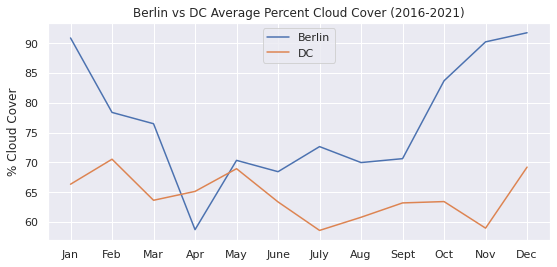

In [44]:
fig, ax = plt.subplots(figsize=(9, 4))

x_pos = list(range(1, 13))
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
ax.set_xticks(x_pos)
ax.set_xticklabels(months)

sns.lineplot(data=clouds_month_BER, x=x_pos, y='cloudcover_BER', ax=ax, label='Berlin')
sns.lineplot(data=clouds_month_DC, x=x_pos, y='cloudcover_DC', ax=ax, label='DC')

ax.legend(loc='upper center')
ax.set_ylabel("% Cloud Cover")
plt.title("Berlin vs DC Average Percent Cloud Cover (2016-2021)")

plt.savefig('Average Percent Cloud Cover by Month.png')

Text(0, 0.5, 'Avg. Sunshine (min.)')

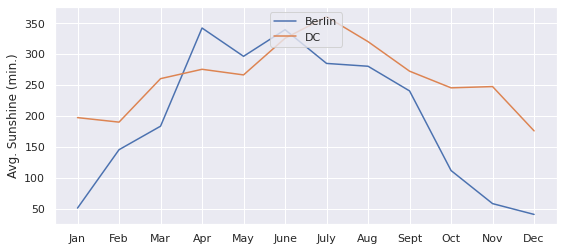

In [45]:
fig0, ax0 = plt.subplots(figsize=(9, 4))

x_pos = list(range(1, 13))
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
ax0.set_xticks(x_pos)
ax0.set_xticklabels(months)

sns.lineplot(data=sundur_month_BER, x=x_pos, y='sunduration_BER', ax=ax0, label='Berlin')
sns.lineplot(data=sundur_month_DC, x=x_pos, y='sunduration_DC', ax=ax0, label='DC')

ax0.legend(loc='upper center')
ax0.set_ylabel("Avg. Sunshine (min.)")
# plt.title("Berlin vs DC Average Percent Cloud Cover (2016-2021)")

# plt.savefig('Average Percent Cloud Cover by Month.png')

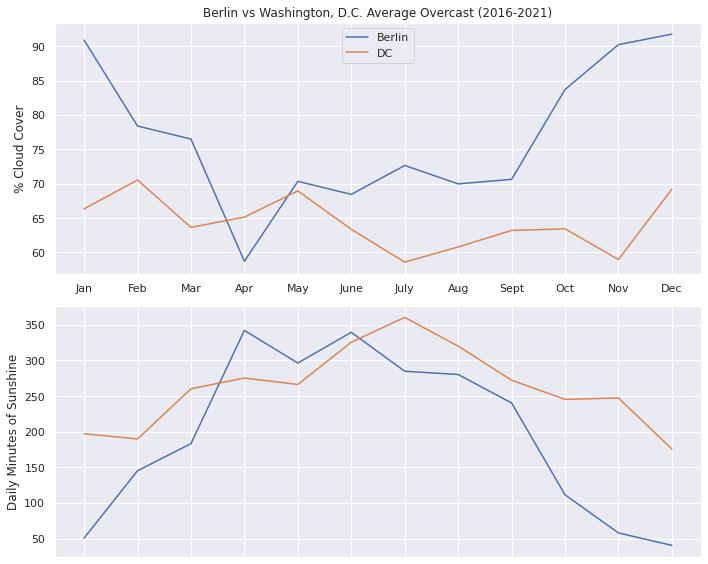

In [46]:
fig1, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

x_pos = list(range(1, 13))
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]
ax1.set_xticks(x_pos)
ax1.set_xticklabels(months)

sns.lineplot(data=clouds_month_BER, x=x_pos, y='cloudcover_BER', ax=ax1, label='Berlin', legend=False)
sns.lineplot(data=clouds_month_DC, x=x_pos, y='cloudcover_DC', ax=ax1, label='DC', legend=False)
ax1.set_ylabel("% Cloud Cover")
ax1.set_title("Berlin vs Washington, D.C. Average Overcast (2016-2021)")

sns.lineplot(data=sundur_month_BER, x=x_pos, y='sunduration_BER', ax=ax2, label='Berlin', legend=False)
sns.lineplot(data=sundur_month_DC, x=x_pos, y='sunduration_DC', ax=ax2, label='DC', legend=False)
ax2.set_ylabel("Daily Minutes of Sunshine")
ax2.set_xticks(x_pos)
ax2.set_xticklabels([])

ax1.legend(loc='upper center')

plt.tight_layout()

# plt.savefig('Average Percent Cloud Cover by Month.png')

### Total sunlight comparison

In [47]:
# dc_suntime = df_riseset['sunset_BER'] - df_riseset['sunrise_BER']
# dc_suntime

# pd.to_timedelta(df_riseset['sunset_BER'])
# (df.fr-df.to).astype('timedelta64[h]')

In [48]:
from datetime import datetime as dt
from datetime import date

In [49]:
df_riseset1 = df_riseset.copy()
df_riseset1['delta_BER'] = df_riseset.apply(lambda x: dt.combine(date.today(), x['sunset_BER']) - dt.combine(date.today(), x['sunrise_BER']), axis=1)
df_riseset1['delta_DC'] = df_riseset.apply(lambda x: dt.combine(date.today(), x['sunset_DC']) - dt.combine(date.today(), x['sunrise_DC']), axis=1)
df_riseset1.set_index('datetime', inplace=True)
# df_riseset1

In [50]:
day_len_BER = df_riseset1['delta_BER'].groupby(df_riseset1.index.month).agg(np.nanmean)
day_len_BER

datetime
1    0 days 08:18:45.408602150
2    0 days 09:56:20.208333333
3    0 days 11:56:36.327956989
4    0 days 14:00:12.011111111
5    0 days 15:48:25.720430107
6    0 days 16:45:05.411111111
7    0 days 16:14:25.274193548
8    0 days 14:36:50.080645161
9    0 days 12:37:19.105555555
10   0 days 10:34:32.037634408
11   0 days 08:43:57.722222222
12   0 days 07:45:03.435483870
Name: delta_BER, dtype: timedelta64[ns]

In [51]:
day_len_DC = df_riseset1['delta_DC'].groupby(df_riseset1.index.month).agg(np.nanmean)

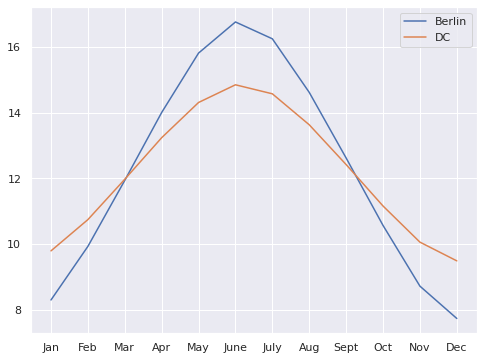

In [52]:
fig10, ax10 = plt.subplots(figsize=(8,6))

ax10.set_xticks(x_pos)
ax10.set_xticklabels(months)

ax10.plot(x_pos, day_len_BER.dt.seconds / 3600, label='Berlin')
ax10.plot(x_pos, day_len_DC.dt.seconds / 3600, label="DC")

plt.legend()